Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time 
    # with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 22.845243
Minibatch accuracy: 7.0%
Validation accuracy: 12.0%
Minibatch loss at step 500: 3.018713
Minibatch accuracy: 72.7%
Validation accuracy: 74.6%
Minibatch loss at step 1000: 1.783425
Minibatch accuracy: 74.2%
Validation accuracy: 77.0%
Minibatch loss at step 1500: 1.150003
Minibatch accuracy: 76.6%
Validation accuracy: 78.8%
Minibatch loss at step 2000: 0.947801
Minibatch accuracy: 84.4%
Validation accuracy: 80.0%
Minibatch loss at step 2500: 0.802964
Minibatch accuracy: 78.9%
Validation accuracy: 79.5%
Minibatch loss at step 3000: 0.763191
Minibatch accuracy: 82.8%
Validation accuracy: 81.1%

Test accuracy: 88.9%


Find the best L2 regularization weight with logistic regression.

In [7]:
num_steps = 3001
regul_weights = [1e-4, 1e-3, 1e-2, 1e-1]  # test different regularization values
accuracy_values = []

for regul_weight in regul_weights:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul_weight}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_values.append(accuracy(test_prediction.eval(), test_labels))

<function matplotlib.pyplot.show>

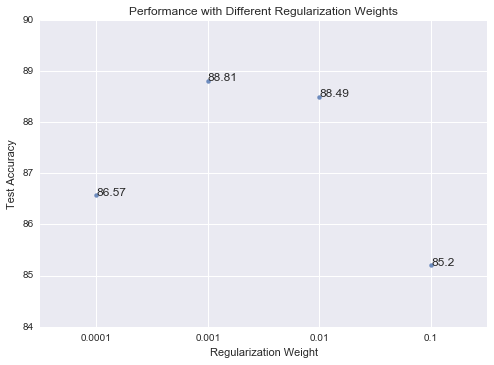

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

x_ticks = np.array([str(i) for i in regul_weights])
x_values = np.array(range(4))
y_values = np.array(accuracy_values)

sns.regplot(x_values, y_values, fit_reg=False)
plt.xticks(x_values, x_ticks)
plt.title('Performance with Different Regularization Weights')
plt.xlabel('Regularization Weight')
plt.ylabel('Test Accuracy')
for i, label in enumerate(y_values):
    plt.annotate(label, (x_values[i], y_values[i]))
plt.show

The best L2 regularization weight is 1e-3.

Add L2 regularization to 2-layer neural network with regularization weight = 1e-3.

In [9]:
batch_size = 128
h1_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time with a 
    # training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, h1_nodes]))
    biases = tf.Variable(tf.zeros([h1_nodes]))
    h1_weights = tf.Variable(tf.truncated_normal([h1_nodes, num_labels]))
    h1_biases = tf.Variable(tf.zeros([num_labels]))
    
    # Add a hidden layer.
    h1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)

    # Training computation.
    logits = tf.matmul(h1_train, h1_weights) + h1_biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
        beta_regul * (tf.nn.l2_loss(weights) + tf.nn.l2_loss(h1_weights))
      
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    h1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    valid_prediction = tf.nn.softmax(tf.matmul(h1_valid, h1_weights) + h1_biases)
    h1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(h1_test, h1_weights) + h1_biases)

In [10]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 668.061157
Minibatch accuracy: 6.2%
Validation accuracy: 29.4%
Minibatch loss at step 500: 193.292816
Minibatch accuracy: 79.7%
Validation accuracy: 78.5%
Minibatch loss at step 1000: 114.451912
Minibatch accuracy: 77.3%
Validation accuracy: 80.4%
Minibatch loss at step 1500: 68.655083
Minibatch accuracy: 82.8%
Validation accuracy: 81.8%
Minibatch loss at step 2000: 41.405796
Minibatch accuracy: 85.2%
Validation accuracy: 82.6%
Minibatch loss at step 2500: 25.154655
Minibatch accuracy: 85.2%
Validation accuracy: 84.9%
Minibatch loss at step 3000: 15.401735
Minibatch accuracy: 86.7%
Validation accuracy: 85.4%

Test accuracy: 92.5%


We get test accuracy above 90% which is a great improvement.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Create an overfitting 2-layer neural network by using a small training set of size 500.

In [11]:
num_steps = 3001

small_train_dataset = train_dataset[:500, :]
small_train_labels = train_labels[:500]

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 606.428101
Minibatch accuracy: 8.6%
Validation accuracy: 30.8%
Minibatch loss at step 500: 190.202942
Minibatch accuracy: 100.0%
Validation accuracy: 73.4%
Minibatch loss at step 1000: 115.349838
Minibatch accuracy: 100.0%
Validation accuracy: 73.3%
Minibatch loss at step 1500: 69.954491
Minibatch accuracy: 100.0%
Validation accuracy: 73.0%
Minibatch loss at step 2000: 42.423779
Minibatch accuracy: 100.0%
Validation accuracy: 73.0%
Minibatch loss at step 2500: 25.728626
Minibatch accuracy: 100.0%
Validation accuracy: 72.9%
Minibatch loss at step 3000: 15.604310
Minibatch accuracy: 100.0%
Validation accuracy: 73.3%

Test accuracy: 82.2%


As we can see, training accuracy gets as high as 100% while validation and test accuracy are both lower than using larger training set in the previous step.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [12]:
batch_size = 128
h1_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time with a 
    # training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, h1_nodes]))
    biases = tf.Variable(tf.zeros([h1_nodes]))
    h1_weights = tf.Variable(tf.truncated_normal([h1_nodes, num_labels]))
    h1_biases = tf.Variable(tf.zeros([num_labels]))
    
    # Add a hidden layer.
    h1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    
    # Add dropout.
    h1_drop = tf.nn.dropout(h1_train, keep_prob)

    # Training computation.
    logits = tf.matmul(h1_drop, h1_weights) + h1_biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
        beta_regul * (tf.nn.l2_loss(weights) + tf.nn.l2_loss(h1_weights))
      
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    h1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    valid_prediction = tf.nn.softmax(tf.matmul(h1_valid, h1_weights) + h1_biases)
    
    h1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(h1_test, h1_weights) + h1_biases)

In [13]:
num_steps = 3001

small_train_dataset = train_dataset[:500, :]
small_train_labels = train_labels[:500]

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3, keep_prob : 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 903.354248
Minibatch accuracy: 8.6%
Validation accuracy: 28.5%
Minibatch loss at step 500: 191.025894
Minibatch accuracy: 100.0%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 115.935913
Minibatch accuracy: 100.0%
Validation accuracy: 75.2%
Minibatch loss at step 1500: 70.329597
Minibatch accuracy: 100.0%
Validation accuracy: 75.7%
Minibatch loss at step 2000: 42.665131
Minibatch accuracy: 100.0%
Validation accuracy: 76.2%
Minibatch loss at step 2500: 25.876102
Minibatch accuracy: 100.0%
Validation accuracy: 75.7%
Minibatch loss at step 3000: 15.693745
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%

Test accuracy: 83.9%


With 0.5 dropout, the overfitting case improves on getting higher validation and test accuracy.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [14]:
batch_size = 128
h1_nodes = 1024
h2_nodes = 300
h3_nodes = 50

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time with a 
    # training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, h1_nodes], 
                                              stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases = tf.Variable(tf.zeros([h1_nodes]))
    h1_weights = tf.Variable(tf.truncated_normal([h1_nodes, h2_nodes], stddev=np.sqrt(2.0 / h1_nodes)))
    h1_biases = tf.Variable(tf.zeros([h2_nodes]))
    h2_weights = tf.Variable(tf.truncated_normal([h2_nodes, h3_nodes], stddev=np.sqrt(2.0 / h2_nodes)))
    h2_biases = tf.Variable(tf.zeros([h3_nodes]))
    h3_weights = tf.Variable(tf.truncated_normal([h3_nodes, num_labels], stddev=np.sqrt(2.0 / h3_nodes)))
    h3_biases = tf.Variable(tf.zeros([num_labels]))
    
    # Add 3 hidden layers with dropout.
    h1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    h2_train = tf.nn.relu(tf.matmul(h1_train, h1_weights) + h1_biases)
    h3_train = tf.nn.relu(tf.matmul(h2_train, h2_weights) + h2_biases)

    # Training computation.
    logits = tf.matmul(h3_train, h3_weights) + h3_biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * \
        (tf.nn.l2_loss(weights) + tf.nn.l2_loss(h1_weights) + tf.nn.l2_loss(h2_weights) + tf.nn.l2_loss(h3_weights))  
      
    # Optimizer. Add decaying learning rate.
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 1000, 0.8, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    h1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    h2_valid = tf.nn.relu(tf.matmul(h1_valid, h1_weights) + h1_biases)
    h3_valid = tf.nn.relu(tf.matmul(h2_valid, h2_weights) + h2_biases)
    valid_prediction = tf.nn.softmax(tf.matmul(h3_valid, h3_weights) + h3_biases)
    
    h1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    h2_test = tf.nn.relu(tf.matmul(h1_test, h1_weights) + h1_biases)
    h3_test = tf.nn.relu(tf.matmul(h2_test, h2_weights) + h2_biases)
    test_prediction = tf.nn.softmax(tf.matmul(h3_test, h3_weights) + h3_biases)

In [15]:
num_steps = 9001  # when decreasing learning rate, number of steps should be increased

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.451322
Minibatch accuracy: 7.0%
Validation accuracy: 39.0%
Minibatch loss at step 500: 1.306375
Minibatch accuracy: 82.8%
Validation accuracy: 84.1%
Minibatch loss at step 1000: 0.977216
Minibatch accuracy: 83.6%
Validation accuracy: 85.8%
Minibatch loss at step 1500: 0.752406
Minibatch accuracy: 88.3%
Validation accuracy: 86.7%
Minibatch loss at step 2000: 0.694403
Minibatch accuracy: 88.3%
Validation accuracy: 87.3%
Minibatch loss at step 2500: 0.522324
Minibatch accuracy: 92.2%
Validation accuracy: 87.8%
Minibatch loss at step 3000: 0.563780
Minibatch accuracy: 90.6%
Validation accuracy: 88.5%
Minibatch loss at step 3500: 0.655389
Minibatch accuracy: 84.4%
Validation accuracy: 88.0%
Minibatch loss at step 4000: 0.468421
Minibatch accuracy: 90.6%
Validation accuracy: 88.6%
Minibatch loss at step 4500: 0.393021
Minibatch accuracy: 92.2%
Validation accuracy: 88.9%
Minibatch loss at step 5000: 0.418853
Minibatch accuracy: 92.2%
Validation accuracy

With 3 hidden layers and decaying learning rate, we can get test accuracy to around 95.6%.